# Example SEND analysis using PyXEM on DLS Jupyterhub

**author: Mohsen Danaie**


This notebook is intended to be run on Diamond's Jupyter hub. See instructions to connect [here](https://diamondlightsource.atlassian.net/wiki/spaces/EPSICWEB/pages/167346199/Instructions+to+connect+to+Diamond+s+JupyterHub)


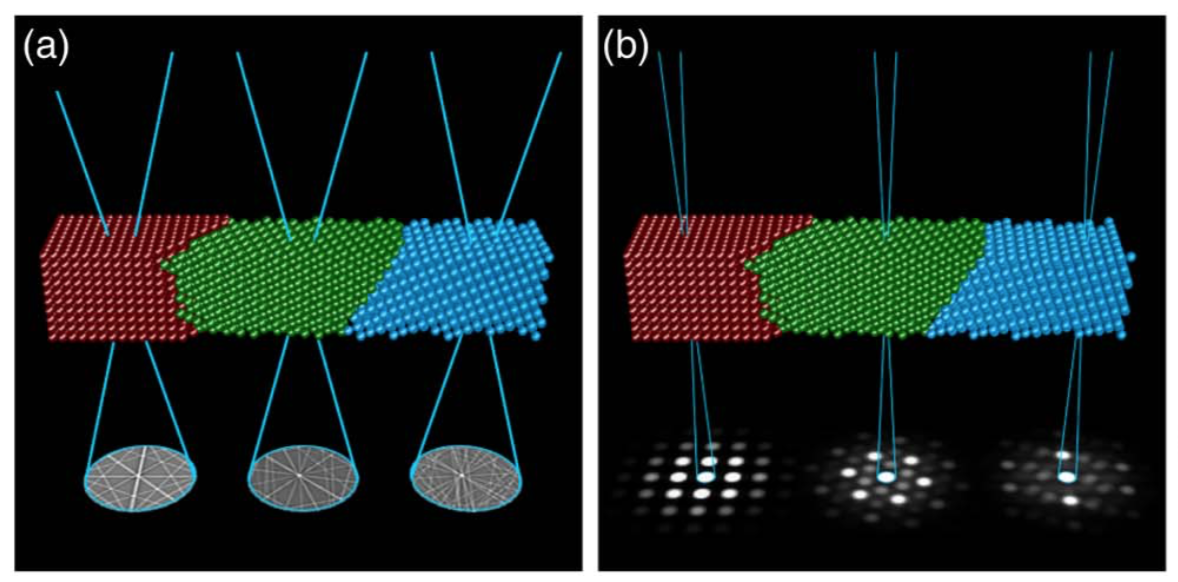

*Reference: Ophus, C. (2019). Four-Dimensional Scanning Transmission Electron Microscopy (4D-STEM): From Scanning Nanodiffraction to Ptychography and Beyond. Microscopy and Microanalysis, 25(3), 563-582. [doi_link](https://doi.org/10.1017/S1431927619000497)*



The 4D-STEM technique refers to a wide range experimental set-up in the transmission electron microscope where the electron beam is rastered across a thin sample and an electron diffraction pattern is recorded post-specimen corresponding to each probe position. This notebook addresses a subgroup of this technique, the so-called Scanning Electron Nanodiffraction (SEND). Here, an electron probe is formed with a small convergence semi-angle (~1 mrad) enabling the diffraction discs from crystalline phases within the sample to be well-resolved, (compare panel b above to a where the probe convergence is large resulting in overlap of diffraction features). SEND can be used for phase, orientation, and strain mapping. 

The demonstration in this notebook covers how we can directly load a raw dataset (17 GB) and visualise it using pyxem. We then go through the calibration routine performed on the data from standard sample (gold cross-grating) to be then applied to other experimental data.



**[(a) Example PyXem functionalities](#pyxem)<br>**

   [- Importing the libraries needed](#setup)<br>
   [- Loading raw data](#load_mib)<br>
   [- Data Visualisation](#vdf)<br>
   

**[(b) Calibrations:](#calibrations)<br>**

   [- Loading files](#load)<br>
   [- Realspace pixel size calibration](#realspace)<br>
   [- Reciprocal space pixel size calibration](#recipspace)<br>
   [- Correction of diffrcation roundness](#diffroundness)<br>
   [- Image / diffraction plane rotation calibration](#scanrot)<br>
   
   


<a id='setup'></a>
## Importing the libraries needed

In [1]:
%matplotlib notebook
import numpy as np
import hyperspy.api as hs
import pyxem as pxm
import matplotlib.pyplot as plt
import os
import sys

from pyxem.libraries.calibration_library import CalibrationDataLibrary
from pyxem.generators.calibration_generator import CalibrationGenerator

import numpy as np
import matplotlib.pyplot as plt

from skimage import data
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft
from scipy.ndimage import fourier_shift

import math

import warnings
warnings.simplefilter(action='ignore')
plt.rcParams.update({'figure.max_open_warning': 0})
warnings.filterwarnings("ignore")

current_path = os.getcwd()
if os.path.exists(os.path.join(current_path, 'epsic_tools')):
    sys.path.append(os.path.join(current_path, 'epsic_tools'))
else:
    !git clone https://github.com/ePSIC-DLS/epsic_tools
    sys.path.append(os.path.join(current_path, 'epsic_tools'))
import epsic_tools.api as epsic

/home/eha56862/.local/lib/python3.7/site-packages/pyUSID/viz/__init__.py:18: FutureWarning: Please use sidpy.viz.plot_utils instead of pyUSID.viz.plot_utils. pyUSID.plot_utils will be removed in a future release of pyUSID
  FutureWarning)


<a id='pyxem'></a>
# (a) Example PyXem functionalities


<a id='load_mib'></a>
## Loading raw data

Using the following method we can load a raw dataset into the notebook lazily:

In [2]:
data = pxm.load_mib('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/expands_notebook/raw_mib/Au_Xgrating_200kX_CL20cm_10um_256_1ms.mib')
print(data)

reshaping using flyback pixel
<LazyElectronDiffraction2D, title: , dimensions: (255, 255|515, 515)>


<a id='vdf'></a>
## Data visualisation by forming virtual dark-field images

For visualisation we need to load into memory:

[########################################] | 100% Completed |  6.8s


<IPython.core.display.Javascript object>


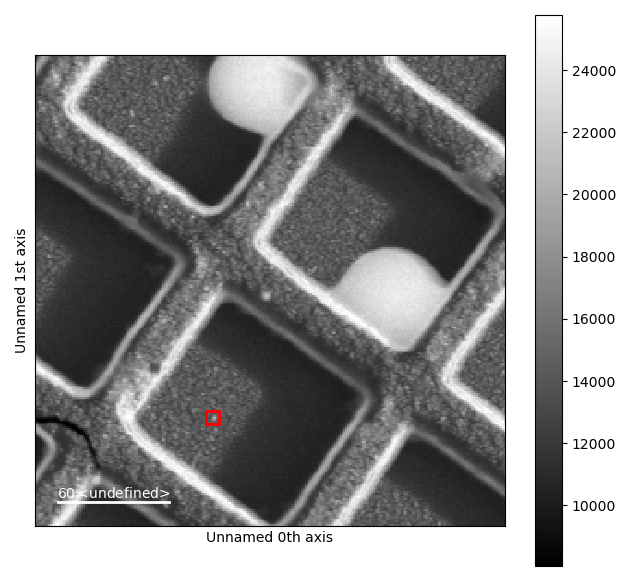

<IPython.core.display.Javascript object>


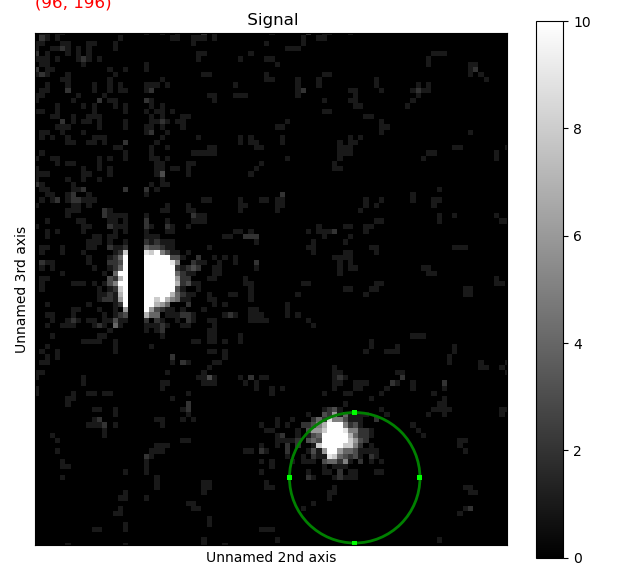

In [3]:
data.compute()
data.plot(vmin=0.,vmax=10)

The green circular region of interest above (this appears after running the cell below), defines a virtual aperture. The sum intensity of this region then is displayed as a virtual dark-field image below. By changing the size and location of the aperture size, the VDF image is updated interactively.

using interactive roi


<IPython.core.display.Javascript object>


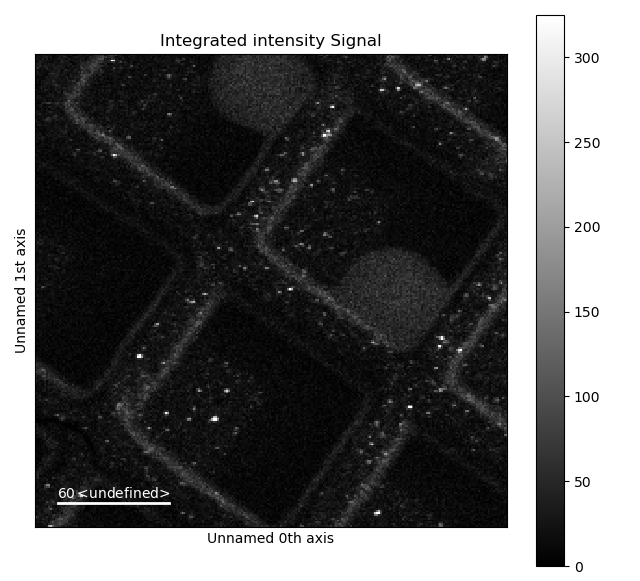

In [4]:
roi = hs.roi.CircleROI(cx=273, cy=319, r=10, r_inner=0)
data.plot_integrated_intensity(roi)

<a id='calibrations'></a>
# (b) Calibrations

<a id='load'></a>
## Loading files 

Loading files from the starndard cross-grating gold sample for the calibrations. Note that these files were converted from raw to hdf5 / hspy and tiff formats. 

In [5]:
base_folder = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/expands_notebook/' 
cals_path = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/expands_notebook/au_xgrating_cals'
mask_path = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/expands_notebook/mask.hspy'

hdf_files = []
hspy_files = []
tiff_files = []
for dirname, dirnames, filenames in os.walk(cals_path):
    for filename in filenames:
        if os.path.splitext(filename)[1] == '.hdf5':
            hdf_files.append(os.path.join(dirname, filename))
        if os.path.splitext(filename)[1] == '.hspy':
            hspy_files.append(os.path.join(dirname, filename))
        if os.path.splitext(filename)[1] == '.tiff':
            tiff_files.append(os.path.join(dirname, filename))
for i, file in enumerate(hspy_files):
    print('[', i, ']', file.split('/')[-1])

[ 0 ] binned_nav_au_xgrating_150kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy
[ 1 ] au_xgrating_150kX_20cmCL_10umAp_subset_dp.hspy
[ 2 ] au_xgrating_150kX_20cmCL_10umAp_ibf.hspy
[ 3 ] au_xgrating_100kX_20cmCL_10umAp_subset_dp.hspy
[ 4 ] binned_nav_au_xgrating_100kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy
[ 5 ] au_xgrating_100kX_20cmCL_10umAp_ibf.hspy
[ 6 ] binned_nav_au_xgrating_200kX_20cmCL_10umAp_scan_array_63by63_diff_plane_515by515__sumdiff.hspy
[ 7 ] au_xgrating_200kX_20cmCL_10umAp_ibf.hspy
[ 8 ] au_xgrating_200kX_20cmCL_10umAp_subset_dp.hspy
[ 9 ] au_xgrating_200kX_40cmCL_10umAp_subset_dp.hspy
[ 10 ] au_xgrating_200kX_40cmCL_10umAp_ibf.hspy
[ 11 ] au_xgrating_100kX_40cmCL_10umAp_ibf.hspy
[ 12 ] au_xgrating_100kX_40cmCL_10umAp_subset_dp.hspy
[ 13 ] au_xgrating_150kX_40cmCL_10umAp_subset_dp.hspy
[ 14 ] au_xgrating_150kX_40cmCL_10umAp_ibf.hspy


<a id='realspace'></a>
## Calibrating real space pixel size

<IPython.core.display.Javascript object>


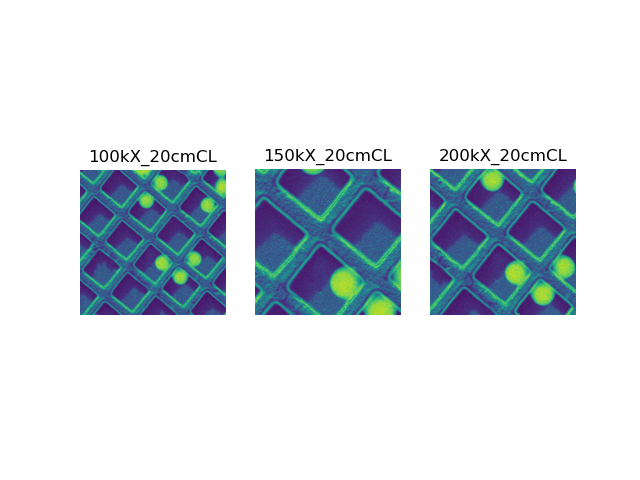

(-0.5, 254.5, 254.5, -0.5)

In [6]:
au_refImages = []

for file in hspy_files:
    if 'au_xgrating_100kX_20cmCL_10umAp_ibf' in file:
        au_refImages.append(file)
    if 'au_xgrating_150kX_20cmCL_10umAp_ibf' in file:
        au_refImages.append(file)
    if 'au_xgrating_200kX_20cmCL_10umAp_ibf' in file:
        au_refImages.append(file)
    

auRefIm = hs.load(au_refImages)

plt.figure()
plt.subplot(131, title = '100kX_20cmCL')
plt.imshow(auRefIm[1].data)
plt.axis('off')
plt.subplot(132, title = '150kX_20cmCL')
plt.imshow(auRefIm[2].data)
plt.axis('off')
plt.subplot(133, title = '200kX_20cmCL')
plt.imshow(auRefIm[0].data)
plt.axis('off')


The pitch of this standard cross-grating sample is known (500 nm). Here we can measure and calibrate pixel sizes - interactively:

<IPython.core.display.Javascript object>


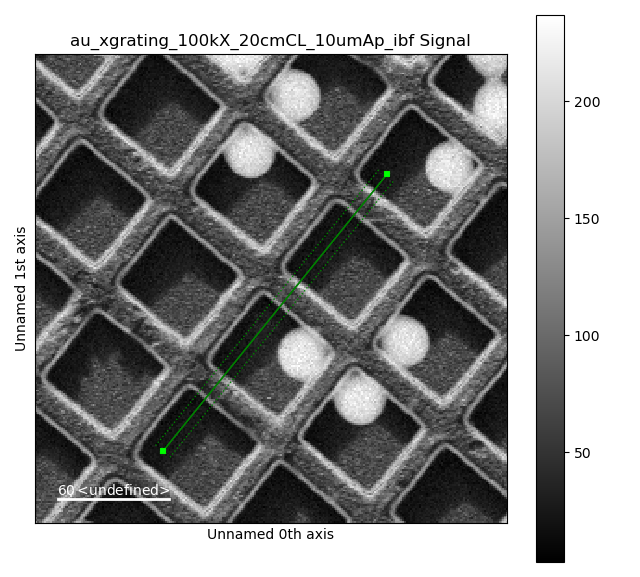

using interactive roi


<IPython.core.display.Javascript object>


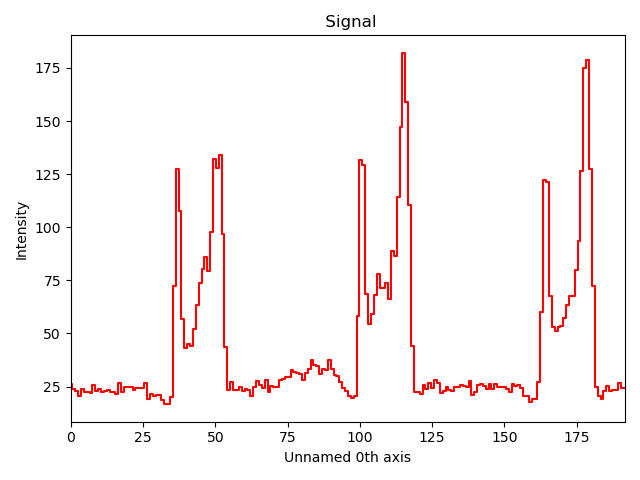

In [7]:
im= auRefIm[1]
im.plot()
line = hs.roi.Line2DROI(x1=68.7, y1=213.96, x2=189.9, y2=64.167, linewidth=10)
line.add_widget(im)      
trace = line.interactive(im)
trace.plot()

In [8]:
MAG = [
    '100kX',
    '150kX',
    '200kX'
]
# pitch of the au cross-grating is 500 nm
nm_per_pixel = [
        np.mean([500 / (101-36.5),500 / (164.7-101)]),
        np.mean([500 / (109.46 - 14.91),500 / (205.97 - 109.46)]),
        np.mean([500 / (134.57 - 10.31),500 / (263.27 - 134.57)])
 ]
FOV = np.asarray(nm_per_pixel) * 256
#dictionary of MAG cal - MAG keys and FOV in nm values
MAG_cal_FOV = dict(zip(MAG, FOV))
print(MAG_cal_FOV)
# save to a file
np.save(os.path.join(base_folder, 'MAG_cal_FOV_nm.npy'), MAG_cal_FOV)

{'100kX': 1996.9576381536517, '150kX': 1340.034249786069, '200kX': 1012.3295878969468}


<a id='recipspace'></a>
## Calibrating reciprocal space pixel size

Reference diffraction data, only using 20 cm CL cases:

<IPython.core.display.Javascript object>


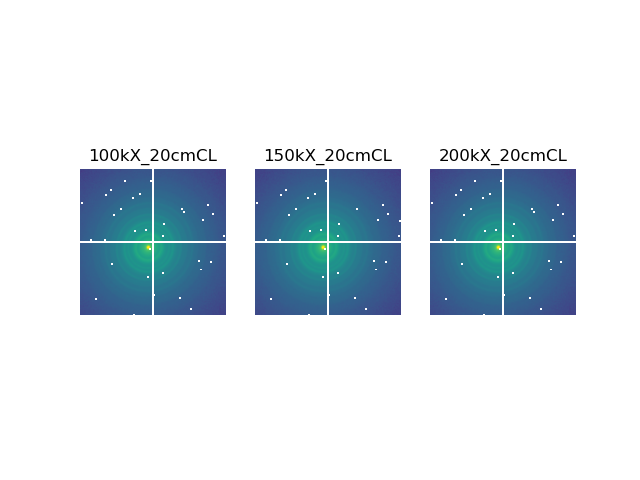

(-0.5, 514.5, 514.5, -0.5)

In [9]:
au_refDiff = []
for file in hspy_files:
    if '_sumdiff' in file:
        au_refDiff.append(file)
auRefDiff = hs.load(au_refDiff)


v_max = 15
plt.figure()
plt.subplot(131, title = '100kX_20cmCL')
plt.imshow(np.log(auRefDiff[2].data), vmax = v_max)
plt.axis('off')
plt.subplot(132, title = '150kX_20cmCL')
plt.imshow(np.log(auRefDiff[1].data), vmax = v_max)
plt.axis('off')
plt.subplot(133, title = '200kX_20cmCL')
plt.imshow(np.log(auRefDiff[2].data), vmax = v_max)
plt.axis('off')


It should not matter which one we choose to analyse here. So continuing with the first pattern:

<IPython.core.display.Javascript object>


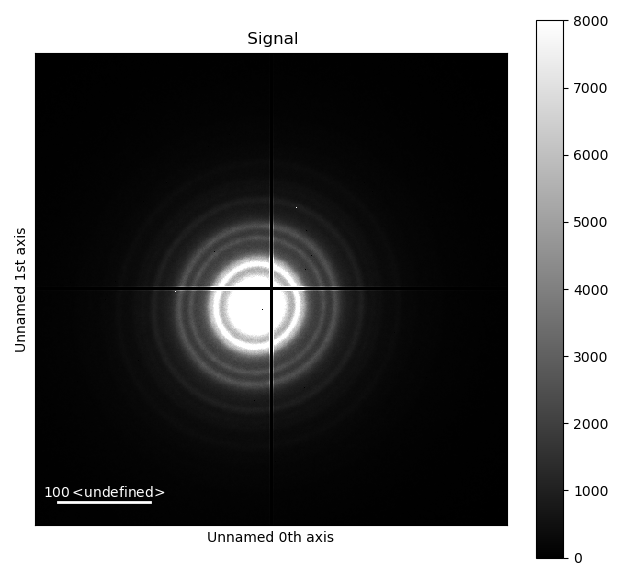

In [10]:
dp = auRefDiff[0]

dp = pxm.signals.ElectronDiffraction2D(dp)
dp.plot(vmax = 8000)

Lets do a rough measurement of pixel size in reciprocal space - interactively:

<IPython.core.display.Javascript object>


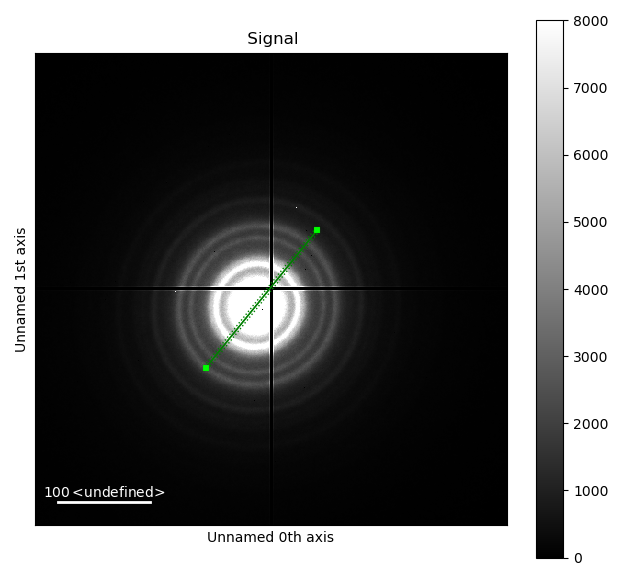

using interactive roi


<IPython.core.display.Javascript object>


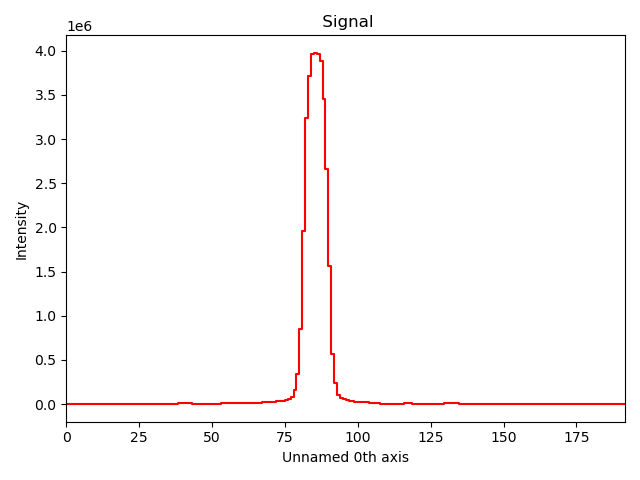

In [11]:
dp.plot(vmax=8000)
line = hs.roi.Line2DROI(x1=186.251, y1=342.793, x2=307.451, y2=193.00, linewidth=5)
line.add_widget(dp)      

trace = line.interactive(dp)
trace.plot()

In [12]:
# centre : 240, 275.5
# 111 ring diam in pixels: 92 - radius 46
# Au 111 reflection (A^-1): 1 / 2.355
diff_cal = (1/2.355) / 46
print(np.round(diff_cal, decimals=5), 'A^-1 to pix')

0.00923 A^-1 to pix


The above value is a rough initial estimate. We will refine this value later in the notebook.

<a id='diffroundness'></a>
## Diffraction roundness correction

First we create a smaller dataset by skipping a number of probe positions, e.g. 10 here:

In [13]:
file = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/expands_notebook/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_.hdf5'
dp_full = hs.load(file, lazy = True)
dp_skip10 = dp_full.inav[::10,::10]
dp_skip10.compute()
# dp_skip10.save('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_skip10.hdf5')# dp_skip10= pxm.load_hspy('/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/au_xgrating_cals/20191018 113710/au_xgrating_150kX_20cmCL_10umAp_scan_array_255by255_diff_plane_515by515_skip10.hdf5')

[########################################] | 100% Completed |  7.0s


Loading the mask and applying it to the skip10 data:

<IPython.core.display.Javascript object>


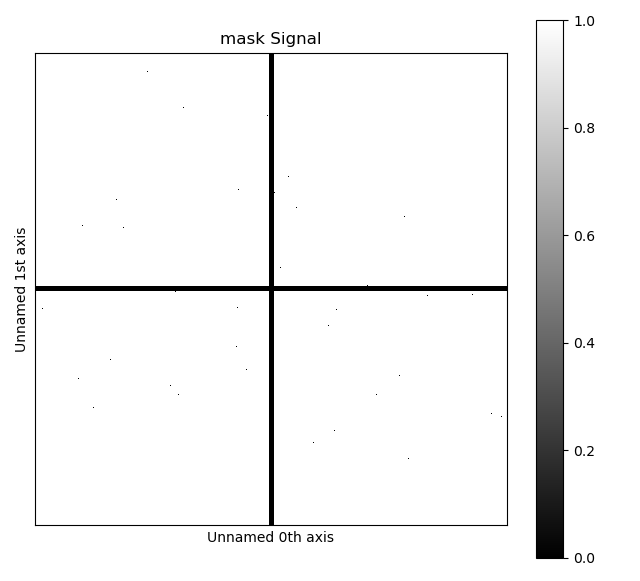

In [14]:
mask = hs.load(mask_path)
mask.plot()
dp_skip10_masked = dp_skip10 * mask
dp_skip10_masked = pxm.signals.ElectronDiffraction2D(dp_skip10_masked)
dp_skip10_masked_sum = dp_skip10_masked.sum()

We need to have the central beam at the centre of the diffraction patterns to continue with this analysis. Here we find the centre of the pattern on the sum diffraction pattern and crop around this position:

In [15]:
centre = pxm.utils.expt_utils.find_beam_center_interpolate(dp_skip10_masked_sum, sigma=5, upsample_factor=4, kind='linear')
print('Coordinates of the centre: ', centre)
det_size = dp_skip10_masked_sum.axes_manager[0].size
crop_size = min(int(det_size - centre[0]),int(det_size - centre[1]), centre[0], centre[1])
print('croped size of the patterns: ', int(2 * crop_size))
dp_skip10_masked_crop = dp_skip10_masked.isig[int(centre[0]-crop_size):int(centre[0]+crop_size), int(centre[1]-crop_size):int(centre[1]+crop_size)]

Coordinates of the centre:  [276.25 241.25]
croped size of the patterns:  476


Now we can correct for shifts in the diffraction pattern by centring the direct beam:

In [16]:
dp_skip10_masked_crop.center_direct_beam(method='interpolate', sigma=5, upsample_factor=4, kind='linear')
dp_skip10_masked_crop.axes_manager[2].offset = 0
dp_skip10_masked_crop.axes_manager[3].offset = 0

[########################################] | 100% Completed |  1.6s


<IPython.core.display.Javascript object>


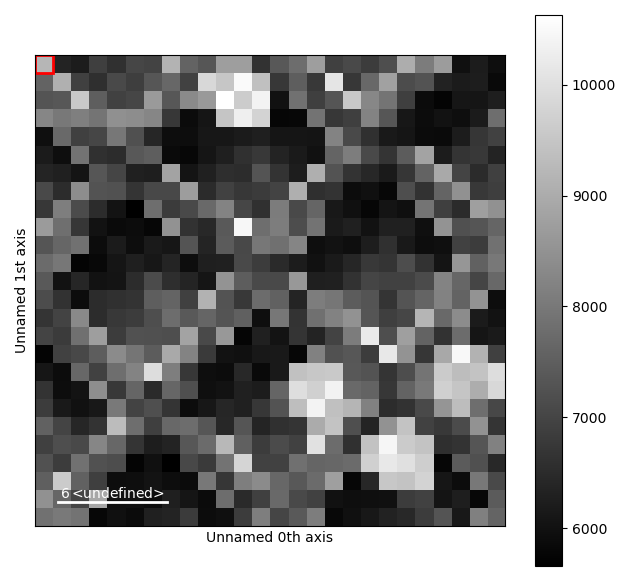

<IPython.core.display.Javascript object>


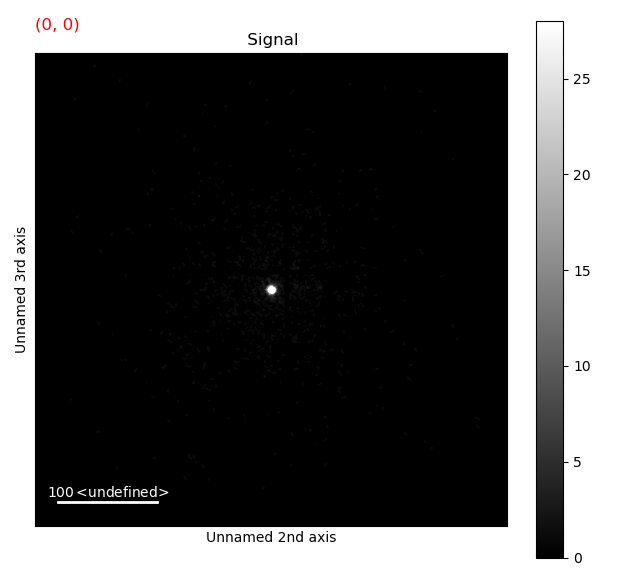

In [17]:
dp_skip10_masked_crop.plot()

After the above correction, we can sum all the diffraction patterns and apply the reciprocal space calibration:

<IPython.core.display.Javascript object>


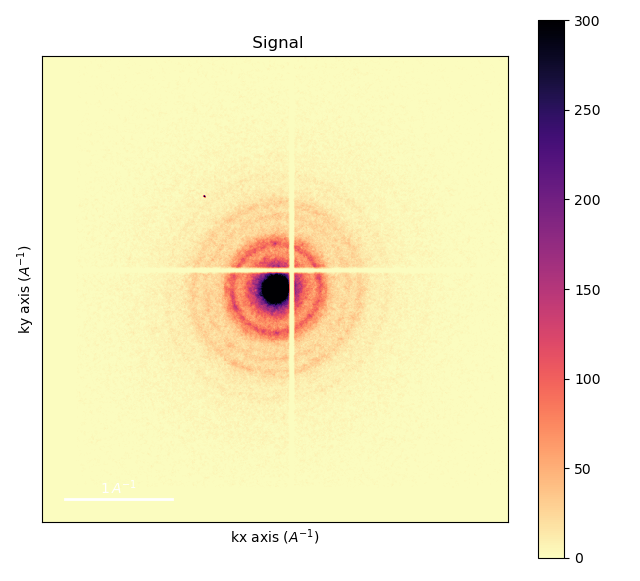

In [18]:
dp_sum = dp_skip10_masked_crop.sum()
dp_sum = pxm.signals.ElectronDiffraction2D(dp_sum)
dp_sum.set_experimental_parameters(beam_energy=300, camera_length=20.)
dp_sum.set_diffraction_calibration(calibration=diff_cal)
cal_lib = CalibrationDataLibrary(au_x_grating_dp=dp_sum)
# cal = CalibrationGenerator(calibration_data=cal_lib)
cal = CalibrationGenerator(diffraction_pattern=dp_sum)
dp_sum.plot(vmax = 300, cmap='magma_r')

Using this pattern we can correct for diffraction roundness:

[[0.9920649  0.01695637 0.        ]
 [0.01695637 0.96376626 0.        ]
 [0.         0.         1.        ]]


  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


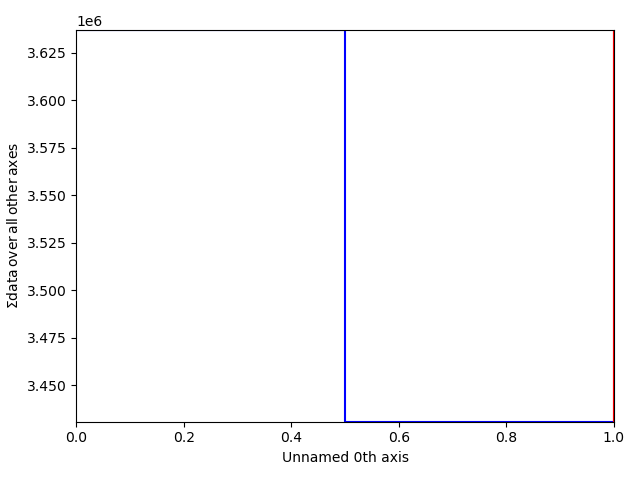

<IPython.core.display.Javascript object>


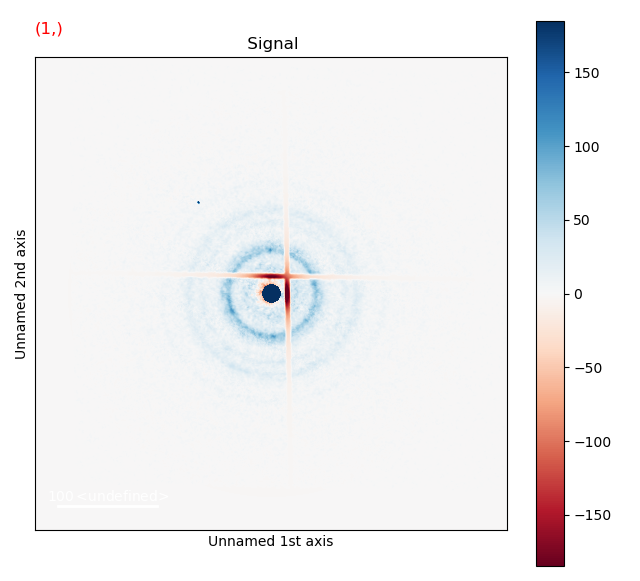

In [19]:
cal.get_elliptical_distortion(mask_radius=10,
                              scale=diff_cal, amplitude=80, direct_beam_amplitude=4e3,
                              asymmetry=0.9,spread=2)
corr_matrix = cal.get_correction_matrix()
print(corr_matrix)
residuals = cal.get_distortion_residuals(mask_radius=10, spread=2)
residuals.plot(cmap='RdBu', vmax=0.005)

  0%|          | 0/4 [00:00<?, ?it/s]

<IPython.core.display.Javascript object>


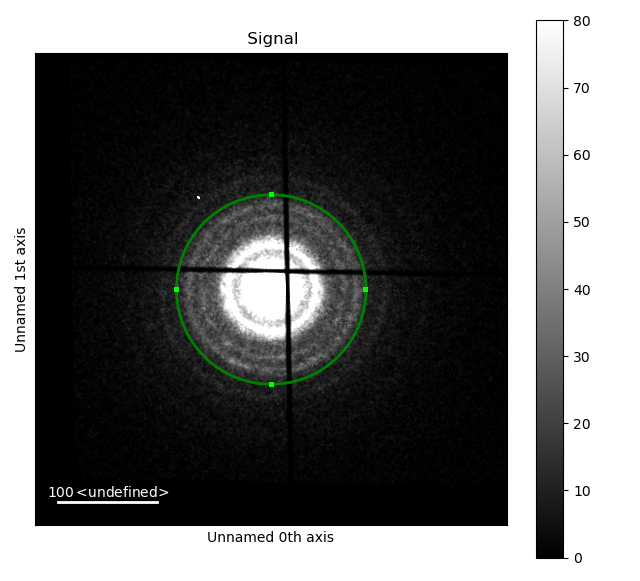

In [20]:
cal.plot_corrected_diffraction_pattern(vmax= 80)

Now we can refine the reciprocal space pixel size

<IPython.core.display.Javascript object>


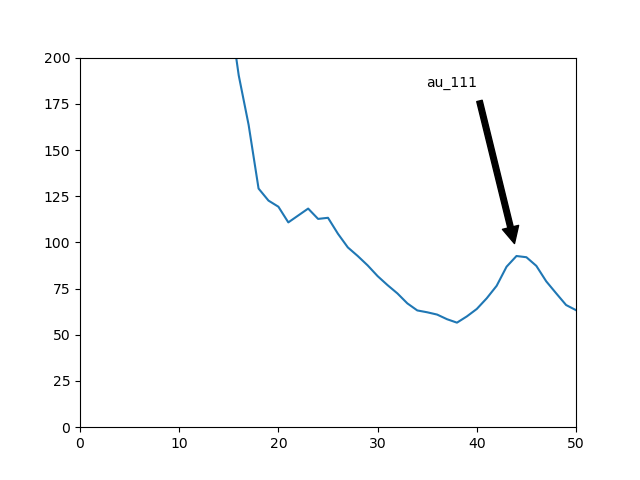

Text(0.8, 0.95, 'au_111')

In [21]:
centre = (int((dp_sum.data.shape[0]/2)), int((dp_sum.data.shape[1]/2)))
profile = epsic.radial_profile.radial_profile(dp_sum.data, centre)
fig, ax = plt.subplots(1,1)
ax.plot(profile)
ax.set_xlim([0, 50])
ax.set_ylim([0, 200])
ax.annotate('au_111', xy=(44, 95),  xycoords='data',
            xytext=(0.8, 0.95), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05),
            horizontalalignment='right', verticalalignment='top',
            )

In [22]:
diff_cal_refined = (1/2.355) / 44.4
print('Initial estimate:', np.round(diff_cal,5), 'A^-1 to pix')
print('Refined value: ', np.round(diff_cal_refined,5), 'A^-1 to pix')

Initial estimate: 0.00923 A^-1 to pix
Refined value:  0.00956 A^-1 to pix


<a id='scanrot'></a>
## Scan rotation calibration

This calibration aims to correct for the rotation angle between the scan coil fast and slow directions and the X/Y axis of the detector. The data we load here is a 4DSTEM dataset of a largely defocused probe (i.e. Ronchigram). We then take two lines corresponding to the slow and fast scan directions. 

In [23]:
scan_data = '/dls/science/groups/e02/Sample_data/sample_pencilbeam_SED_data/expands_notebook/au_xgrating_cals/scan_rot/20201214_153300.hdf5'
scan = hs.load(scan_data, lazy = True)
fast_dir = scan.inav[1:,60]
slow_dir = scan.inav[60,1:]
fast_dir.compute()
slow_dir.compute()

[########################################] | 100% Completed |  1.5s
[########################################] | 100% Completed |  6.5s


<IPython.core.display.Javascript object>


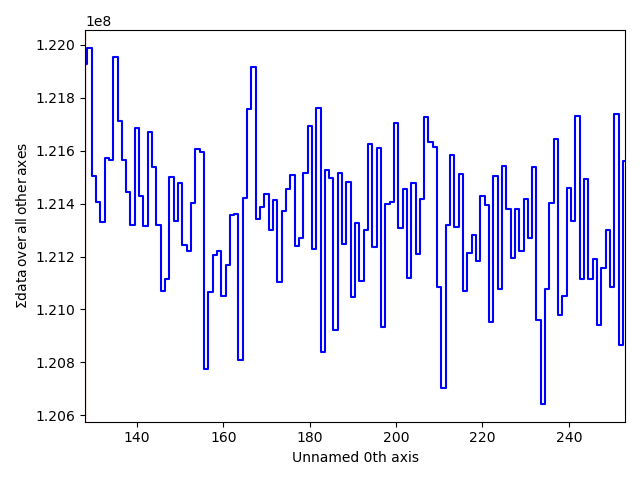

<IPython.core.display.Javascript object>


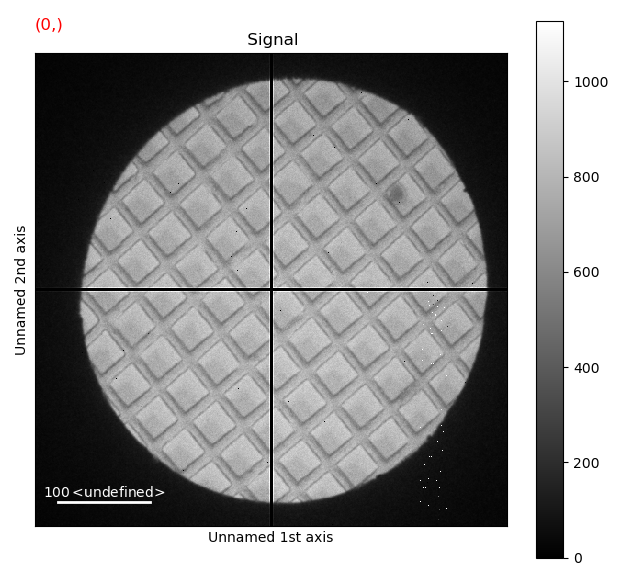

In [24]:
slow_dir.plot()

Cropping to the area within the bright-field disc, removing the cross, and applying a Gaussian blur to better track the motion:

<IPython.core.display.Javascript object>


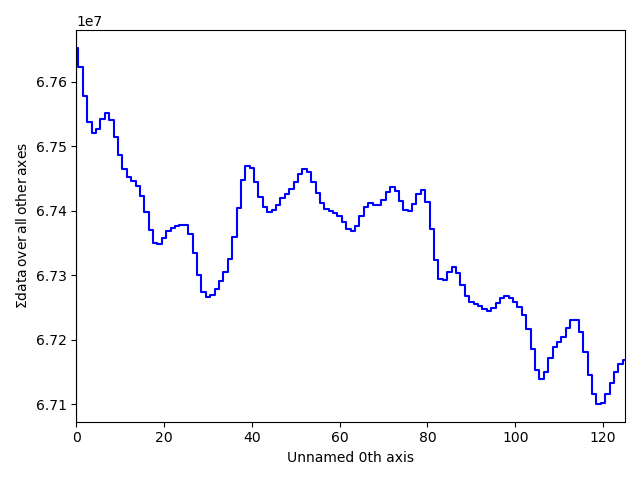

<IPython.core.display.Javascript object>


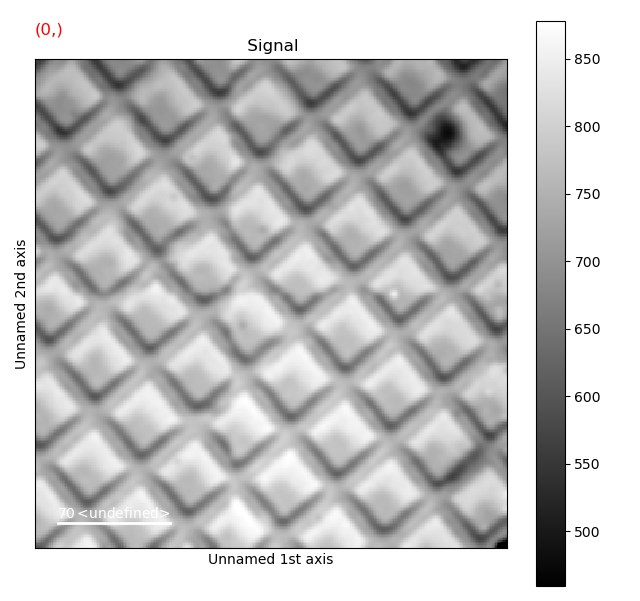

In [25]:
index = [255,256,257,258,259]
fast_dir_no_cross = np.delete(fast_dir.data, index, axis = 1)
fast_dir_no_cross = np.delete(fast_dir_no_cross, index, axis = 2)
slow_dir_no_cross = np.delete(slow_dir.data, index, axis = 1)
slow_dir_no_cross = np.delete(slow_dir_no_cross, index, axis = 2)
fast_dir_no_cross = hs.signals.Signal2D(fast_dir_no_cross)
slow_dir_no_cross = hs.signals.Signal2D(slow_dir_no_cross)
fast_dir_crop = fast_dir_no_cross.isig[132:429, 108:415]
slow_dir_crop = slow_dir_no_cross.isig[132:429, 108:415]
from scipy.ndimage import gaussian_filter
fast_dir_crop_gb = gaussian_filter(fast_dir_crop.data, sigma = 2)
fast_dir_crop_gb = hs.signals.Signal2D(fast_dir_crop_gb)
slow_dir_crop_gb = gaussian_filter(slow_dir_crop.data, sigma = 2)
slow_dir_crop_gb = hs.signals.Signal2D(slow_dir_crop_gb)
slow_dir_crop_gb.plot()

estimate the shifts in the image:

In [26]:
shifts_slow = slow_dir_crop_gb.inav[:20].estimate_shift2D('current', roi = (132,292,150,300), normalize_corr=True)
shifts_fast = fast_dir_crop_gb.inav[:20].estimate_shift2D('current', roi = (132,292,150,300), normalize_corr=True)

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [27]:
shifts_slow = np.asarray(shifts_slow)
print(np.sum(shifts_slow, axis=0))
shifts_slow_sum = np.sum(shifts_slow, axis=0)
shifts_fast = np.asarray(shifts_fast)
print(np.sum(shifts_fast, axis=0))
shifts_fast_sum = np.sum(shifts_fast, axis=0)

[ 42 160]
[-170   30]


<IPython.core.display.Javascript object>


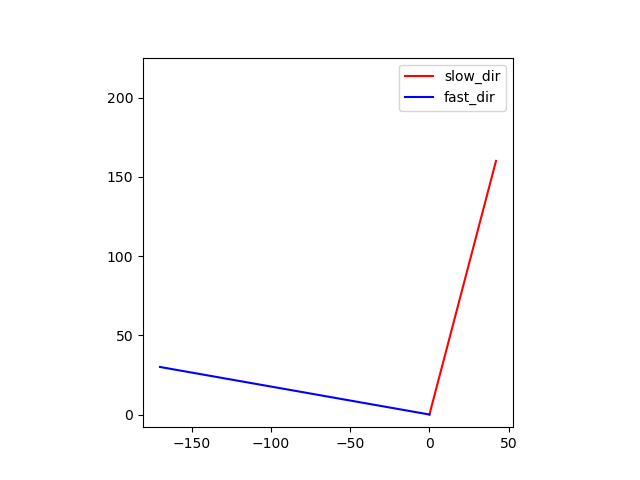

In [28]:
plt.figure()
plt.plot([0, shifts_slow_sum[0]], [0, shifts_slow_sum[1]], '-r', label = 'slow_dir')
plt.plot([0, shifts_fast_sum[0]], [0, shifts_fast_sum[1]], '-b', label = 'fast_dir') 
plt.axis('square')
plt.legend()

104.70830389968275


<IPython.core.display.Javascript object>


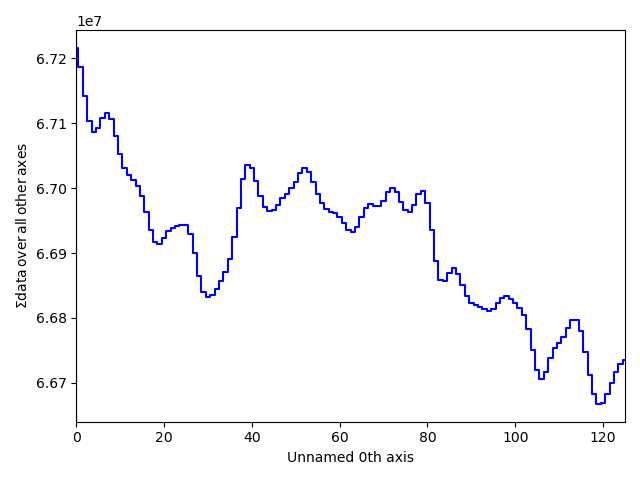

<IPython.core.display.Javascript object>


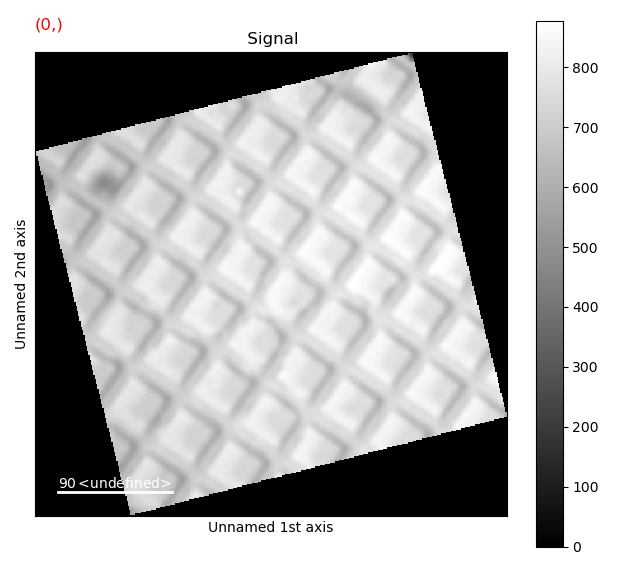

In [29]:
import scipy
rot_angle = (abs(math.degrees(math.atan(shifts_fast_sum[1]/shifts_fast_sum[0])))
            + 180 - abs(math.degrees(math.atan(shifts_fast_sum[1]/shifts_fast_sum[0])))
            - abs(math.degrees(math.atan(shifts_slow_sum[1]/shifts_slow_sum[0]))))
print(rot_angle)
slow_dir_crop_gb_rot = scipy.ndimage.rotate(slow_dir_crop_gb.data, angle=rot_angle, axes = (1,2))
slow_dir_crop_gb_rot = hs.signals.Signal2D(slow_dir_crop_gb_rot)
slow_dir_crop_gb_rot.plot()

<IPython.core.display.Javascript object>


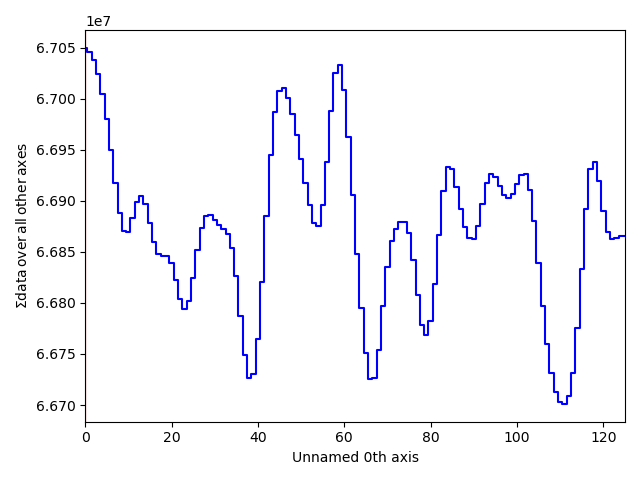

<IPython.core.display.Javascript object>


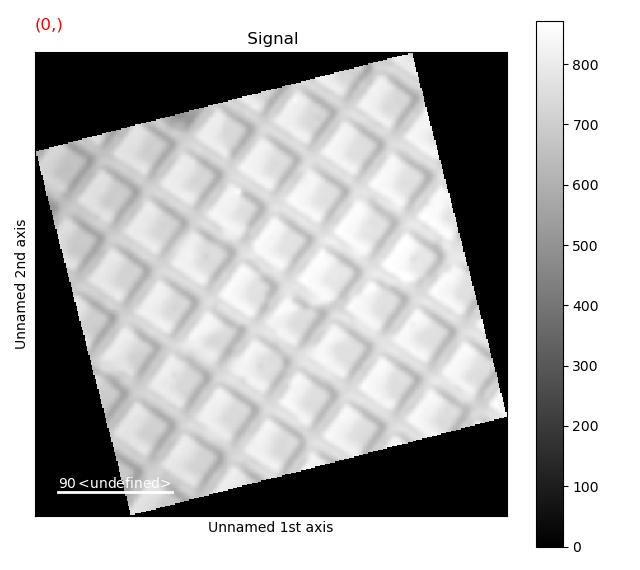

In [30]:
fast_dir_crop_gb_rot = scipy.ndimage.rotate(fast_dir_crop_gb.data, angle=rot_angle, axes = (1,2))
fast_dir_crop_gb_rot = hs.signals.Signal2D(fast_dir_crop_gb_rot)
fast_dir_crop_gb_rot.plot()

With the parameters reached in this notebook we can now calibrate all the subsequent experimental SEND datasets.